In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
# rcParams['figure.figsize'] = 5, 4
# rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# select device: change to 'cpu' if there's no GPU device
device = 'gpu'

if device == 'gpu':
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

if device == 'cpu':
    torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
class ScaleAndShift(nn.Module):
    def __init__(self, input_features, K=1):
        super(ScaleAndShift, self).__init__()
        self.input_features = input_features # Dimension of parameter space p
        self.K = K # Number of mixtures

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        
        self.logscale = nn.Parameter(torch.Tensor(input_features,K)) # Matrix dim=[p,K]
        self.shift = nn.Parameter(torch.Tensor(input_features,K)) # Matrix dim=[p,K]

        self.logscale.data.uniform_(-1, 1)
        self.shift.data.uniform_(-1, 1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        
        # input dimension dim=[batch_no,p]
        batch_no = input.shape[0] # Number of batch simulation as the first dimension
        p = self.input_features # Dimension of parameter space
        
        K = self.K # Number of mixtures
        
#         self.logscale = self.scale_raw  # torch.tanh(self.scale_raw)
        self.scale = torch.exp(self.logscale)
        
        x_rep = input.reshape([batch_no,1,p]).repeat(1,K,1)  # Tensor of dimension [batch_no,K,p]
        w_rep = self.scale.T.reshape([1,K,p]).repeat(batch_no,1,1) # Tensor of dimension [batch_no,K,p]
        b_rep = self.shift.T.reshape([1,K,p]).repeat(batch_no,1,1) # Tensor of dimension [batch_no,K,p]

        return x_rep*w_rep+b_rep # Tensor of dimension [batch_no,K,p]. Element-wise location-scale change from beta to theta coefficient . eq (6) in the paper 

    def print_param(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        scale = torch.exp(self.logscale)
        return 'scale={}, shift={}'.format(
            scale, self.shift
        )

In [53]:
class KCat(nn.Module):
    def __init__(self, input_features, K=1):
        super(KCat, self).__init__()
        self.input_features = input_features # Dimension of parameter space p
        self.K = K # Number of mixtures
        
        self.w = nn.Parameter(torch.Tensor(input_features,K)) # a_k parameter in Eq(7) in the paper. Tensor of dimension [p,K]
        self.b0 = nn.Parameter(torch.Tensor(K)) # unnormalized log(b_k) parameter in Eq(7) in the paper. Tensor of dimension [K]

        self.w.data.uniform_(-1, 1)
        self.b0.data.uniform_(-1, 1)

        
    def forward(self, input,dim=1):
        # theta values are the input of this function. input dimension dim=[batch_no,K,p]
        # b leaves in the log-space
        b = self.b0 - torch.logsumexp(self.b0,0,keepdim=True) #exp(b)=exp(b0)/(sum exp(b0)) so b is the log of the normalized exp(b0) vector, i.e. sum(exp(b)) = 1
        
        xw_b = input@self.w+ b # = a_k^T * theta +log(b_k) in Eq(7) of the paper. input dim=[p], self.w dim=[p,K], b dim=[K];   @: matrix vector multiplication in python
        return xw_b - torch.logsumexp(xw_b,dim=dim,keepdim=True) # Weight are normalized to sum to 1

In [5]:
batch_no = 1000
p = 2  # Dimension of the parameter space
K = 100  # Number of mixture components

In [6]:
scale_shift = ScaleAndShift(p,K)
kcat = KCat(p,K)

In [7]:
scale_shift.print_param()

'scale=tensor([[0.4406, 2.1844, 0.4117, 0.8860, 1.4614, 0.7852, 0.8350, 0.4921, 0.5739,\n         2.6364, 1.4093, 2.2280, 0.8419, 0.4059, 1.8315, 2.6288, 0.4078, 0.4906,\n         0.7341, 2.2176, 2.1727, 0.5510, 1.2997, 1.0629, 2.3101, 0.8701, 1.7089,\n         1.6066, 0.6523, 1.9084, 0.6930, 1.4014, 0.7564, 1.5538, 1.8218, 0.6018,\n         2.2735, 0.5780, 2.0217, 1.2455, 1.1889, 0.7302, 1.2440, 0.5470, 1.7386,\n         1.0856, 1.6422, 0.9019, 1.8181, 1.0341, 1.4031, 2.2507, 0.7897, 1.5691,\n         1.7524, 0.4177, 2.4571, 0.9428, 1.8398, 2.5643, 0.6913, 1.2387, 0.7639,\n         1.1708, 2.3796, 1.2698, 0.6952, 0.6223, 0.4390, 0.4293, 0.6664, 0.4191,\n         0.4069, 0.9626, 0.4259, 1.7484, 0.4324, 0.4740, 0.7806, 1.4997, 1.6875,\n         0.4329, 0.3883, 2.6806, 0.8852, 2.5744, 0.3723, 1.8179, 1.3034, 2.1539,\n         0.5290, 0.5988, 1.7488, 2.4367, 0.6941, 0.6888, 2.4634, 0.6204, 2.6569,\n         1.2278],\n        [1.2219, 1.3685, 0.6757, 0.3716, 1.4646, 1.4957, 1.2878, 0.8109,

In [8]:
# scale_shift.logscale is a matrix of dimension [p,K]
scale_shift.logscale.data.size()


torch.Size([2, 100])

In [9]:
# scale_shift.shift is a matrix of dimension [p,K]
print("shift type: ",type(scale_shift.shift))
print("shift size: ",scale_shift.shift.data.size())
print("shift first element in first dimension: ",scale_shift.shift[0][0:5])
print("shift first element in second dimension: ",scale_shift.shift[1][0:5])
print("shift :",scale_shift.shift[:,:5])
print("Shift transpose size",scale_shift.shift.T.size())# T is for transpose
print("shift transpose first element in first dimension: ",scale_shift.shift.T[0][0:2])
print("shift transpose first element in second dimension: ",scale_shift.shift.T[1][0:2])
print("shift transpose: ",scale_shift.shift.T[:5,:])

shift type:  <class 'torch.nn.parameter.Parameter'>
shift size:  torch.Size([2, 100])
shift first element in first dimension:  tensor([-0.6627, -0.6918, -0.6461,  0.3744, -0.8960], grad_fn=<SliceBackward>)
shift first element in second dimension:  tensor([ 0.3208,  0.9905,  0.9815, -0.7954,  0.0470], grad_fn=<SliceBackward>)
shift : tensor([[-0.6627, -0.6918, -0.6461,  0.3744, -0.8960],
        [ 0.3208,  0.9905,  0.9815, -0.7954,  0.0470]],
       grad_fn=<SliceBackward>)
Shift transpose size torch.Size([100, 2])
shift transpose first element in first dimension:  tensor([-0.6627,  0.3208], grad_fn=<SliceBackward>)
shift transpose first element in second dimension:  tensor([-0.6918,  0.9905], grad_fn=<SliceBackward>)
shift transpose:  tensor([[-0.6627,  0.3208],
        [-0.6918,  0.9905],
        [-0.6461,  0.9815],
        [ 0.3744, -0.7954],
        [-0.8960,  0.0470]], grad_fn=<SliceBackward>)


In [10]:
# Using torch tensor
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(x)
print(x[0])
print(x[0][2])

tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([1, 2, 3])
tensor(3)


In [11]:
batch_no = 6
print("shift T:",scale_shift.shift.T[:5,:])
print("shift transpose size: ",scale_shift.shift.T.size())
print("shift transpose after reshape (notice one more bracket):",scale_shift.shift.T.reshape([1,K,p])[:,:5,:])
print("shift transpose after reshape dimension: ",scale_shift.shift.T.reshape([1,K,p]).size())
print("shift transpose after reshape (notice one more bracket):",scale_shift.shift.T.reshape([1,K,p])[:,:5,:])
print("shift transpose after reshape and repeat: ",scale_shift.shift.T.reshape([1,K,p]).repeat(batch_no,1,1)[:3,:5,:])
print("shift transpose after reshape and repeat dimension: ",scale_shift.shift.T.reshape([1,K,p]).repeat(batch_no,1,1).size())
# x_rep*w_rep+b_rep # Tensor of dimension [batch_no,K,p]. Element-wise multiplication between x_rep and w_rep. 


shift T: tensor([[-0.6627,  0.3208],
        [-0.6918,  0.9905],
        [-0.6461,  0.9815],
        [ 0.3744, -0.7954],
        [-0.8960,  0.0470]], grad_fn=<SliceBackward>)
shift transpose size:  torch.Size([100, 2])
shift transpose after reshape (notice one more bracket): tensor([[[-0.6627,  0.3208],
         [-0.6918,  0.9905],
         [-0.6461,  0.9815],
         [ 0.3744, -0.7954],
         [-0.8960,  0.0470]]], grad_fn=<SliceBackward>)
shift transpose after reshape dimension:  torch.Size([1, 100, 2])
shift transpose after reshape (notice one more bracket): tensor([[[-0.6627,  0.3208],
         [-0.6918,  0.9905],
         [-0.6461,  0.9815],
         [ 0.3744, -0.7954],
         [-0.8960,  0.0470]]], grad_fn=<SliceBackward>)
shift transpose after reshape and repeat:  tensor([[[-0.6627,  0.3208],
         [-0.6918,  0.9905],
         [-0.6461,  0.9815],
         [ 0.3744, -0.7954],
         [-0.8960,  0.0470]],

        [[-0.6627,  0.3208],
         [-0.6918,  0.9905],
         

In [12]:
scale_shift.shift.T.size()

torch.Size([100, 2])

In [13]:
class Loglik(nn.Module):
    def __init__(self):
        super(Loglik, self).__init__()
        
        # Parameter of the mixture
        # theta |y ~ + 0.5 N([5 ; 2],[1 0.5; 0.5 1]) + 0.5 N([-3 ; -1],[1*s1^2 -0.9*s1 ; -0.9*s1 1]) 
        s1 = 1
        
        # Covariance matrices of the 2 mixture components
        sigma0 = 1
        Sigma1 = torch.tensor(np.reshape(np.array([1,0.5,0.5,1], np.float64),[2,2])) * sigma0**2
        Sigma2 = torch.tensor(np.reshape(np.array([1*s1**2,-0.9*s1,-0.9*s1,1], np.float64),[2,2])) * sigma0**2

        self.Omega1 = (Sigma1).inverse()
        self.Omega2 = (Sigma2).inverse()

        # Mode of the gaussian distribution
        self.Mu1 = torch.tensor(np.matrix([5,2]))
        self.Mu2 = torch.tensor(np.matrix([-3,-1]))

        # log determinant of the covariance matrices
        self.logSigma1 = torch.logdet(Sigma1)
        self.logSigma2 = torch.logdet(Sigma2)
              
    def f(self, theta):
        # Calculate the likelihood of a theta for the mixture posterior
        # logLik of one Gaussian N(mu,Sigma) with dim(mu)= n:       logLik = -0.5*n*log(2*pi) - log(det(Sigma))/2.0 - (x-mu)^T*\Sigma^(-1)*(x-mu)/2.0
        # Here n = 2:  logLik = -log(2*pi) - log(det(Sigma))/2.0 - (x-mu)^T*\Sigma^(-1)*(x-mu)/2.0
        #              logLik = -log(2*pi) - log(det(Sigma))/2.0 - quad/2.0  with quad = (x-mu)^T*\Sigma^(-1)*(x-mu)
        #
        # logLik of the mixture of two gaussians: (See https://stephens999.github.io/fiveMinuteStats/intro_to_em.html)
        # Lik = 0.5*N(M1,Sigma1) + 0.5 *N(Mu2,Sigma2)
        # logLik = log( sum_{k=1..K} [0.5 * N(M1,Sigma1) ; 0.5 * N(Mu2,Sigma2)])  with K=2
        #        = log(0.5) + log( sum_{k=1..K} [N(M1,Sigma1) ; N(Mu2,Sigma2)])
        #        = log(0.5) + log( sum_{k=1..K} exp [ - quad1/2.0 - logdet(Sigma1)/2.0 -log(2*pi) ; - quad2/2.0 - logdet(Sigma2)/2.0 -log(2*pi)])
        #        = log(0.5) - log(2*pi) + log( sum_{k=1..K} exp [ - quad1/2.0 - logdet(Sigma1)/2.0  ; - quad2/2.0 - logdet(Sigma2)/2.0 ])
        Mu1 = self.Mu1
        Mu2 = self.Mu2
        Omega1 = self.Omega1
        Omega2 = self.Omega2
        logSigma1 = self.logSigma1
        logSigma2 = self.logSigma2

        diff1 = (theta-Mu1) # theta dim = 1,2
        quad1 = torch.diagonal( diff1@Omega1@torch.transpose(diff1,1,2),dim1=1,dim2=2) # matrix multiplication (theta-Mu1) x Omega1 x (theta-Mu1)^T

        diff2 = (theta-Mu2)
        quad2 = torch.diagonal( diff2@Omega2@torch.transpose(diff2,1,2),dim1=1,dim2=2)

        comp_loglik1 =  - quad1/2.0 - logSigma1/2.0 
        comp_loglik2 = - quad2/2.0 - logSigma2/2.0 

        loglik = torch.logsumexp(torch.stack([comp_loglik1,comp_loglik2]),dim=0) + np.log(0.5) -np.log(2*np.pi) # sum in logsumexp over the number of mixtures
        return  loglik

compLoglik = Loglik()

In [14]:
print("Mu1: ",torch.tensor(np.matrix([5,2])))
print("Mu1 dim:",torch.tensor(np.matrix([5,2])).size())

Mu1:  tensor([[5, 2]])
Mu1 dim: torch.Size([1, 2])


In [32]:
para_list=list()
para_list +=  list(scale_shift.parameters()) #logscale dim=[p,K], shift dim=[p,K]; use to calculate exp(log_scale)*input+shift
para_list +=  list(kcat.parameters())# w dim=[p,K], b0 dim=[K] ; use to calculate  b = log(exp(b0)/sum(exp(b0))), xw_b = input @ w+ b, xw_b - logsumexp(xw_b)
print("Number of parameter:",len(para_list))
print("Dimension of each parameter:",list(map(lambda x: x.data.size(),para_list)))


Number of parameter: 4
Dimension of each parameter: [torch.Size([2, 100]), torch.Size([2, 100]), torch.Size([2, 100]), torch.Size([100])]


Optimize to learn the random transport, as a mixture of K maps

In [18]:

def dirichlet_prior(logb):
    alpha= 0.5
    return (alpha/K-1) * log_b.sum()

In [33]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-1)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)

In [52]:
r = 10.
print("Number of betas with all the batches",[batch_no,p])
beta = torch.rand([batch_no,p])* r - r/2.
print("beta size:",beta.size())
# beta is the input in the scale_shift.forward function with imension dim=[batch_no,p]
theta = scale_shift(beta)
print("theta size:",theta.size())
mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2)  
print("kcat(beta): ",kcat(theta,dim=2).size())
print("mix_weight: ",mix_weight.size())

Number of betas with all the batches [6, 2]
beta size: torch.Size([6, 2])
theta size: torch.Size([6, 100, 2])
kcat(beta):  torch.Size([6, 100, 100])
mix_weight:  torch.Size([6, 100])


In [70]:
# Calculation performed in kcat(theta,dim=2)
dim=2
b0=kcat.b0
w=kcat.w
input=theta
print("b0 dim",b0.size())
print("w dim",w.size())
print("input dim",input.size())
# theta values are the input of this function. input dimension dim=[batch_no,K,p]
# b leaves in the log-space
#   torch.logsumexp(input, dim, keepdim=False, *, out=None)
#     Returns the log of summed exponentials of each row of the input tensor in the given dimension dim. The computation is numerically stabilized.
# We sum other the first and unique dimension of b0
b = b0 - torch.logsumexp(b0,0,keepdim=True) #exp(b)=exp(b0)/(sum exp(b0)) so b is the log of the normalized exp(b0) vector, i.e. sum(exp(b)) = 1
print("b dim:",b.size())

# xw_b[batch_no,K,K] = input[batch_no,K,p] @ w[p,K] + b[K] 
xw_b = input@w+ b # = a_k^T * theta +log(b_k) in Eq(7) of the paper. input dim=[p], self.w dim=[p,K], b dim=[K];   @: matrix vector multiplication in python
print("xw_b dim:",xw_b.size()) #xw_b dim=[batch_no,K,K]

res=xw_b - torch.logsumexp(xw_b,dim=dim,keepdim=True) # Weight are normalized to sum to 1 for the third index (dim=2) which is indexing the mixture number of dimension K
print("xw_b normalized dim:",res.size()) #xw_b normazlied dim=[batch_no,K,K]

print("xw_b normalized first batch",res[0,:5,:5])
print("xw_b normalized second batch",res[1,:5,:5])



b0 dim torch.Size([100])
w dim torch.Size([2, 100])
input dim torch.Size([6, 100, 2])
b dim: torch.Size([100])
xw_b dim: torch.Size([6, 100, 100])
xw_b normalized dim: torch.Size([6, 100, 100])
xw_b normalized first batch tensor([[-45.3447, -49.3438, -34.3537, -28.9337, -43.6342],
        [ -8.8377, -10.0317,  -9.1254,  -6.8380,  -8.9227],
        [-12.7556, -12.3430,  -4.5576,  -6.9909, -11.3781],
        [-18.3371, -18.2337,  -8.1100, -10.3519, -16.6307],
        [-16.2230, -16.6370,  -8.8528,  -9.5501, -15.0083]],
       grad_fn=<SliceBackward>)
xw_b normalized second batch tensor([[-162.4698, -182.5580, -155.2478, -118.4554, -161.8709],
        [ -43.2031,  -48.2196,  -39.2951,  -30.5511,  -42.7037],
        [ -26.9023,  -25.0183,   -6.1906,  -13.8759,  -23.3949],
        [ -34.0383,  -36.1227,  -22.5371,  -20.8627,  -32.1852],
        [ -50.2851,  -54.4646,  -37.0298,  -31.7097,  -48.2026]],
       grad_fn=<SliceBackward>)
mix_weight dim torch.Size([6, 100])


In [75]:
# Only one diagonal is considered in the calculation of mix_weight from kcat
kcat_theta = kcat(theta,dim=2)
print("kcat(theta) dim",kcat_theta.size())
print("kcat(theta) first batch",kcat_theta[0,:5,:5])
print("kcat(theta) second batch",kcat_theta[1,:5,:5])
mix_weight = torch.diagonal(kcat_theta,0,1,2) #kcat(beta) 
print("mix_weight dim",mix_weight.size())
print("mix_weight first batch",mix_weight[0,:5])
print("mix_weight second batch",mix_weight[1,:5])

kcat(theta) dim torch.Size([6, 100, 100])
kcat(theta) first batch tensor([[-45.3447, -49.3438, -34.3537, -28.9337, -43.6342],
        [ -8.8377, -10.0317,  -9.1254,  -6.8380,  -8.9227],
        [-12.7556, -12.3430,  -4.5576,  -6.9909, -11.3781],
        [-18.3371, -18.2337,  -8.1100, -10.3519, -16.6307],
        [-16.2230, -16.6370,  -8.8528,  -9.5501, -15.0083]],
       grad_fn=<SliceBackward>)
kcat(theta) second batch tensor([[-162.4698, -182.5580, -155.2478, -118.4554, -161.8709],
        [ -43.2031,  -48.2196,  -39.2951,  -30.5511,  -42.7037],
        [ -26.9023,  -25.0183,   -6.1906,  -13.8759,  -23.3949],
        [ -34.0383,  -36.1227,  -22.5371,  -20.8627,  -32.1852],
        [ -50.2851,  -54.4646,  -37.0298,  -31.7097,  -48.2026]],
       grad_fn=<SliceBackward>)
mix_weight dim torch.Size([6, 100])
mix_weight first batch tensor([-45.3447, -10.0317,  -4.5576, -10.3519, -15.0083],
       grad_fn=<SliceBackward>)
mix_weight second batch tensor([-162.4698,  -48.2196,   -6.1906,  -2

In [20]:
import copy
best_loss = np.inf

#for t in range(3000):
for t in range(300):
    
    # Sample new beta values between [0,1) and scale them betwen [-r/2 ; r/2], here between [-5;5]
    r = 10.
    beta = torch.rand([batch_no,p])* r - r/2. 

    # Calculate the new thetas from the element-wise location-change function
    theta = scale_shift(beta) 

    # Calculate the mixture weight w_k(theta) from Eq(7) in the paper
    #   torch.diagonal(input, offset=0, dim1=0, dim2=1) → Tensor
    #        Returns a partial view of input with the its diagonal elements with respect to dim1 and dim2 appended as a dimension at the end of the shape.
    #        The argument offset controls which diagonal to consider:
    #        If offset = 0, it is the main diagonal.
    #           Parameters
    #            input (Tensor) – the input tensor. Must be at least 2-dimensional.
    #            offset (int, optional) – which diagonal to consider. Default: 0 (main diagonal).
    #            dim1 (int, optional) – first dimension with respect to which to take diagonal. Default: 0.
    #            dim2 (int, optional) – second dimension with respect to which to take diagonal. Default: 1.
    mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2) #kcat(beta) 

    # Jacobian of the transport function for one mixture component is Prod_{j=1..p} s_{k,j}   s_{k,j}=exp(scale_shift.logscale[j,k]) ; as shwon below Eq(6) in the paper
    # scale_shift.logscale dim=[p,K]
    # So logJacobian = sum_{j=1..p} scale_shift.logscale[j,k] = scale_shift.logscale.sum(0) ; summed of the first dimension corresponding to paramete index j=1..p
    logjacobian = scale_shift.logscale.sum(0) 

    #
    target_log_density = compLoglik.f(theta) + logjacobian

    weighted_target = target_log_density + mix_weight


    total = torch.logsumexp(weighted_target,dim=1)
    
    #regularize b:    
    log_b = kcat.b0 - torch.logsumexp(kcat.b0,0, keepdim=True)
    w = kcat.w    

    # Calculate the loss function over the average of the different batches
    loss =  - total.mean()

    # Add dirichlet prior on the b coefficients
    total_loss =  loss  + dirichlet_prior(log_b)   
    
    if t%100==0:
        print(t, np.log(1.0/100.0) - total.mean())
          

    # If improved save new best loss
    if loss.item()< best_loss:
        param_bak = copy.deepcopy( [scale_shift.state_dict(), kcat.state_dict()])
        best_loss = loss.item()

   # if Nan values in the loss function     
    if np.isnan(loss.item()):
        scale_shift = ScaleAndShift(p,K)
        kcat = KCat(p,K)
        scale_shift.load_state_dict(param_bak[0])
        kcat.load_state_dict(param_bak[1])
        kcat.eval()
        scale_shift.eval()
#         optimizer.zero_grad()
        pass
          
    
    # Clears the gradients of all optimized torch.Tensors
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    # Use total_loss for the optimization
    total_loss.backward(retain_graph=True)

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 tensor(5.3959, grad_fn=<RsubBackward1>)
100 tensor(0.4947, grad_fn=<RsubBackward1>)
200 tensor(0.9725, grad_fn=<RsubBackward1>)


# New Section

In [21]:
def getNp(x):
    return x.detach().cpu().numpy()

In [22]:
g= getNp( np.log(1.0/100.0) - total[:1000])


In [23]:
g.mean()

0.5946920124074556

In [24]:
beta

tensor([[-1.9876, -1.1712],
        [-4.1208, -3.9690],
        [-1.6808, -4.7506],
        [ 2.7634,  4.7372],
        [-3.8886, -1.0320],
        [ 0.1840,  3.0752]])

In [25]:
post_sample_beta=list()
post_sample_theta=list()
post_sample_choice =list()
post_sample_map_choice =list()

for i in range(50):
    theta = scale_shift(beta)
    mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2) #kcat(beta)
#     mix_weight = torch.stack([kcat(theta[:,k,:])[:,k] for k in range(K)],dim=1)
    logjacobian = scale_shift.logscale.sum(0)

    target_log_density = compLoglik.f(theta) + logjacobian

    weighted_target = target_log_density + mix_weight
    theta_np = getNp(theta)

    weight_np =getNp(weighted_target)

    pick = np.argmax(weight_np+ np.random.gumbel(size= [batch_no,K]),axis=1)
    map_pick = np.argmax(weight_np,axis=1)

    post_sample_beta.append(getNp(beta))
    post_sample_theta.append(np.array([theta_np[i,pick[i],:] for i in range(batch_no)]))
    post_sample_choice.append(pick)
    post_sample_map_choice.append(map_pick)

beta_sample = np.vstack(post_sample_beta)
theta_sample = np.vstack(post_sample_theta)
post_sample_choice = np.hstack(post_sample_choice)
post_sample_map_choice = np.hstack(post_sample_map_choice)

In [26]:
rcParams['figure.dpi'] = 300

(-10.0, 10.0)

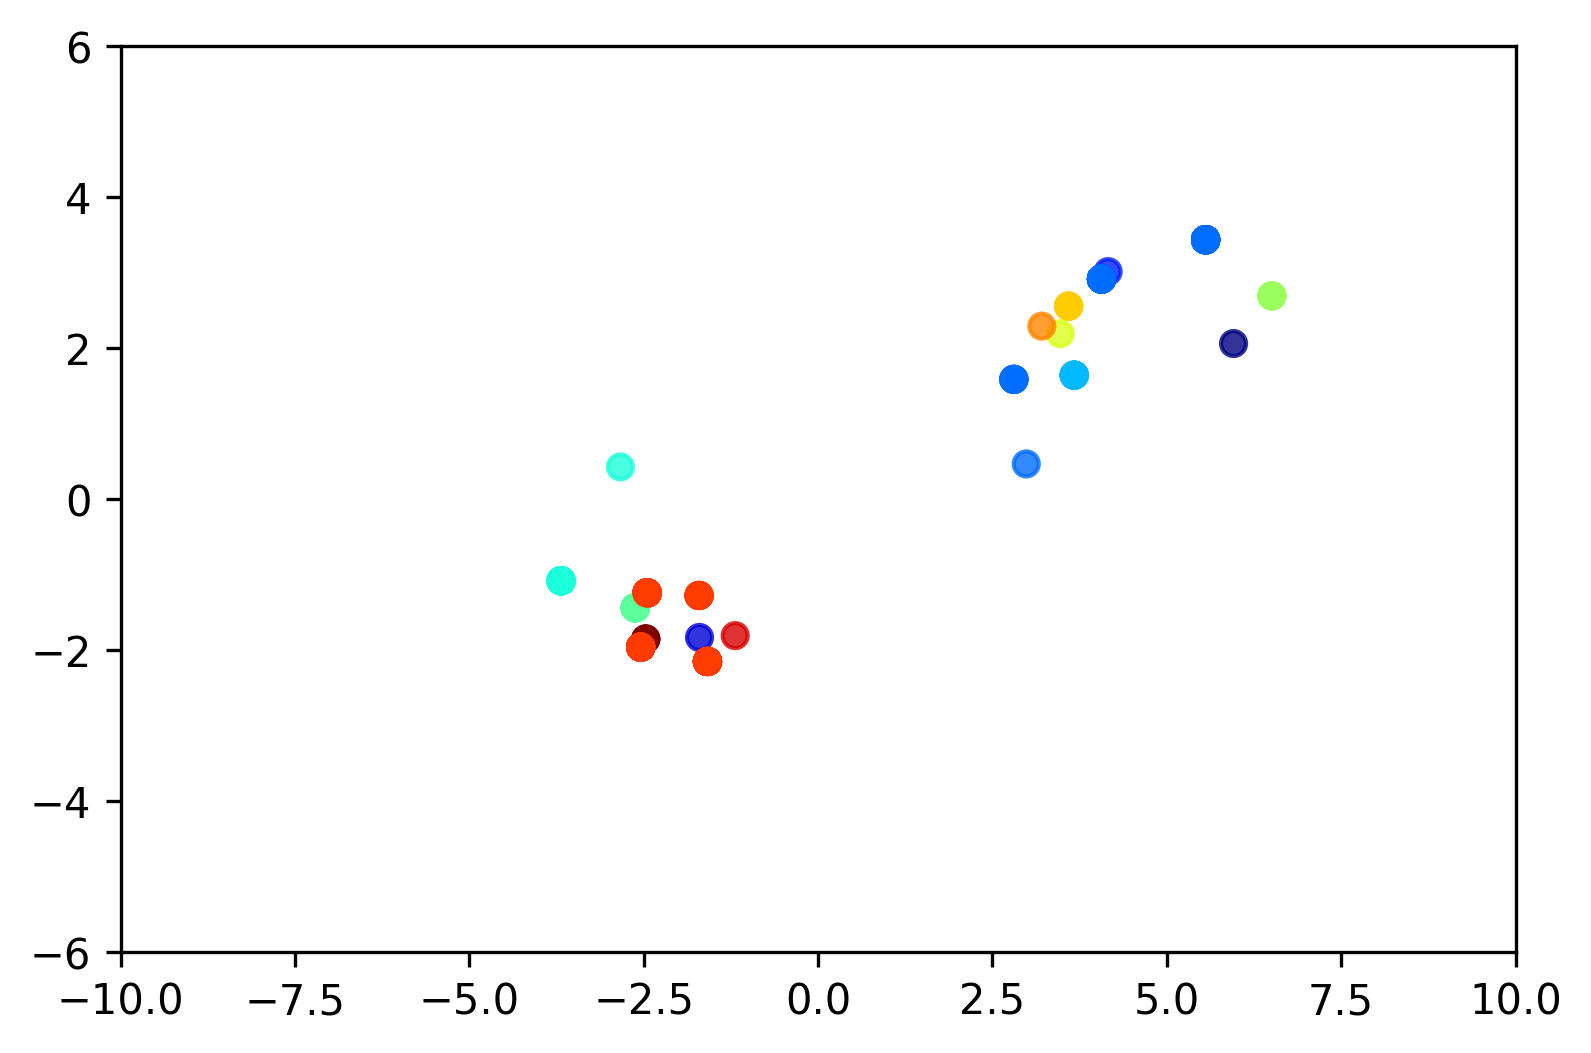

In [27]:
col = post_sample_choice
_, col1 = np.unique(col, return_inverse=True)


plot_n = 3000
plt.figure(figsize=[6, 4])
plt.scatter(theta_sample[:plot_n,0],theta_sample[:plot_n,1],c=col1[:plot_n], alpha=.8,cmap='jet_r')
plt.ylim(-6,6)
plt.xlim(-10,10)